In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE, BorderlineSMOTE 

from helper_functions.classification import *
from helper_functions.botnet_profiling_task import *
from helper_functions.flow_data_discretization import *
# warnings.filterwarnings("ignore")

In [11]:
infected_hosts = ['147.32.84.165','147.32.84.191','147.32.84.192','147.32.84.193','147.32.84.204',
                  '147.32.84.205','147.32.84.206', '147.32.84.207','147.32.84.208','147.32.84.209']

normal_hosts = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

In [3]:
data = pd.read_csv('./data/capture20110818.pcap.netflow.labeled.remastered')
data[['Src_IP_Addr', 'Src_Port']] = data['Src_IP_Addr:Port'].str.split(':', n=1, expand=True)
data[['Dst_IP_Addr', 'Dst_Port']] = data['Dst_IP_Addr:Port'].str.split(':', n=1, expand=True)

data['Datetime'] = data['#Date_flow'].str.cat(data['start'], sep=' ')
#data['Datetime'] = pd.to_datetime(data['Datetime'], infer_datetime_format=True)

data.drop(labels=['#Date_flow', 'start', 'Src_IP_Addr:Port', 'Dst_IP_Addr:Port'], axis=1, inplace=True)
data.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Label,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port,Datetime
0,0.002,TCP,FRPA_,0,4,321,1,Background,147.32.86.166,33426,212.24.150.110,25443,2011-08-18 10:19:13.328
1,4.995,UDP,INT,0,617,40095,1,Background,82.39.2.249,41915,147.32.84.59,43087,2011-08-18 10:19:13.328
2,4.996,UDP,INT,0,1290,1909200,1,Background,147.32.84.59,43087,82.39.2.249,41915,2011-08-18 10:19:13.329
3,0.000,TCP,A_,0,1,66,1,Background,147.32.86.166,42020,147.32.192.34,993,2011-08-18 10:19:13.330
4,0.000,TCP,FPA_,0,2,169,1,Background,212.24.150.110,25443,147.32.86.166,33426,2011-08-18 10:19:13.330


In [4]:
data_nobground = data[ data['Label'] != 'Background']
data_nobground.shape
data_nobground.head()

del data

In [5]:
# Storing the mapping used for the conversion, in case we want to revert back 
label_mapping = {}


label_mapping['Label'] = {'LEGITIMATE':0, 'Botnet':1}
data_nobground.replace({'Label' : label_mapping['Label']}, inplace=True)

# Convert all the rest columns which are of type 'object'
char_cols = ['Prot', 'Flags']

for c in char_cols:
    data_nobground[c], label_mapping[c] = pd.factorize(data_nobground[c])

# Uncomment this line, if you want to see the mapppings for the conversion
label_mapping

{'Label': {'LEGITIMATE': 0, 'Botnet': 1},
 'Prot': Index(['TCP', 'UDP', 'ICMP'], dtype='object'),
 'Flags': Index(['PA_', 'A_', 'FA_', 'SPA_', 'FPA_', 'INT', 'FSA_', '_FSA', 'FSPA_',
        '_FSPA', 'S_', 'RA_', 'FSRPA_', 'SA_', '_FSRPA', 'SRPA_', 'FRPA_',
        'ECO', 'URH', 'SR_', 'FRA_', 'RPA_', 'R_', 'FSPAEC_', 'SRA_', '_FSRA',
        'URP', 'PAC_', 'MAS', 'TST', 'IRR', 'ECR', 'RTS', 'RTA', 'IRQ', 'UNK',
        'MSR', 'TSR', 'SEC', 'ROB', 'MRQ', 'RED', 'IAH', 'TXD', 'DNQ', 'PTB',
        'PAR', 'NRA', 'WAY', 'PHO', '___', 'AHA', 'NRS', 'MHR', 'UR', 'NNA',
        'MRP', 'TRC', 'DCE', 'SKP', 'SRC', 'NNS', 'DNP', 'URN', 'URPRE', 'URS',
        'URNU', 'URCUT', 'URISO', 'URNPRO', 'URHPRO', 'URHTOS', 'URHU', 'SPAC_',
        'SEC_', 'FSRA_', 'URFIL', 'FSPAC_'],
       dtype='object')}

## Discrete

In [12]:
test_hosts = np.append(infected_hosts[1:], normal_hosts[1:])
test_hosts

array(['147.32.84.191', '147.32.84.192', '147.32.84.193', '147.32.84.204',
       '147.32.84.205', '147.32.84.206', '147.32.84.207', '147.32.84.208',
       '147.32.84.209', '147.32.84.134', '147.32.84.164', '147.32.87.36',
       '147.32.80.9', '147.32.87.11'], dtype='<U13')

In [13]:
ranks = 2

packets = data_nobground['Packets'].values
data_nobground['Disc_Packets'] = discretize_ordinal(packets, ranks)

In [14]:
n = 2 
feat = ['Prot', 'Disc_Packets']
use_smoothing = False

# Extracting the infected training profile
infected_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == infected_hosts[0], data_nobground['Dst_IP_Addr']==infected_hosts[0])]
infected_data = infected_data[feat].values

infected_code, _ = extract_code(infected_data)
infected_ngrams = extract_ngrams(infected_code, n)
unique_infected_ngrams, unique_infected_counts = np.unique(infected_ngrams, axis=0, return_counts=True)
if use_smoothing:
    max_unigram = np.max(unique_infected_ngrams)
    smoothed_infected_ngrams, smoothed_infected_counts = laplace_smoothing(unique_infected_ngrams, unique_infected_counts, max_unigram)
    _, infected_prof, infected_sorted_prof = extract_profile(smoothed_infected_ngrams, smoothed_infected_counts)
else:
    _, infected_prof, infected_sorted_prof = extract_profile(unique_infected_ngrams, unique_infected_counts)

# Extracting the normal profile
normal_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == normal_hosts[0], data_nobground['Dst_IP_Addr']==normal_hosts[0])]
normal_data = normal_data[feat].values

normal_code, _ = extract_code(normal_data)
normal_ngrams = extract_ngrams(normal_code, n)
unique_normal_ngrams, unique_normal_counts = np.unique(normal_ngrams, axis=0, return_counts=True)
if use_smoothing:
    smoothed_normal_ngrams, smoothed_normal_counts = laplace_smoothing(unique_normal_ngrams, unique_normal_counts, max_unigram)
    _, normal_prof, normal_sorted_prof = extract_profile(smoothed_normal_ngrams, smoothed_normal_counts)
else:
    _, normal_prof, normal_sorted_prof = extract_profile(unique_normal_ngrams, unique_normal_counts)

In [17]:
pred = np.zeros(len(test_hosts), dtype=int)
i=0
for host in test_hosts:
    host_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == host, data_nobground['Dst_IP_Addr']==host)]
    if len(host_data)<n:
#         print(host, len(host_data), '\n')
        i = i+1
        continue
    host_data = host_data[feat].values
    if host in infected_hosts:
        host_data[:,1] = 1
    
    host_code, _ = extract_code(host_data)
    host_ngrams = extract_ngrams(host_code, n)
    unique_host_ngrams, unique_host_counts = np.unique(host_ngrams, axis=0, return_counts=True)
    if use_smoothing:
        smoothed_host_ngrams, smoothed_host_counts = laplace_smoothing(unique_host_ngrams, unique_host_counts, max_unigram)
        _, host_prof, sorted_host_prof = extract_profile(smoothed_host_ngrams, smoothed_host_counts)
    else:
        _, host_prof, sorted_host_prof = extract_profile(unique_host_ngrams, unique_host_counts)
    
    normal_distance = distance(normal_prof, host_prof, normal_sorted_prof, sorted_host_prof, 2)
    infected_distance = distance(infected_prof, host_prof, infected_sorted_prof, sorted_host_prof, 2)
    
    print(host, normal_distance, infected_distance)
    if infected_distance < normal_distance:
        
        pred[i] = 1

    i = i+1

147.32.84.191 14.807843124877216 12.27442275322146
147.32.84.192 14.84089131993831 12.036581276623828
147.32.84.193 14.46490030637481 12.562196359461414
147.32.84.204 14.750423656852744 12.884101213479537
147.32.84.205 14.917606332503993 11.384842746175078
147.32.84.206 14.51456219080532 13.09418679004854
147.32.84.207 14.50434566494421 12.94648842590981
147.32.84.208 14.859585504332706 12.372431744225006
147.32.84.209 14.39336976834814 13.137175471469149
147.32.84.134 1.088094695258738 6.723669716018827
147.32.84.164 0.7706928831529345 6.445780858926657
147.32.87.36 1.4993154575822765 3.8579689061516693
147.32.80.9 12.937225458750717 14.516932912523624


In [48]:
TP = np.sum(np.isin(test_hosts[pred==1], infected_hosts))
FP = np.sum(pred==1) - TP
TN = np.sum(np.isin(test_hosts[pred==0], infected_hosts, invert=True))
FN = np.sum(pred==0) - TN
print("TP: ", TP)
print("FP: ", FP)
print("FN: ", FN)
print("TN:", TN)
print(TP+FP+TN+FN)

TP:  9
FP:  0
FN:  0
TN: 4
13


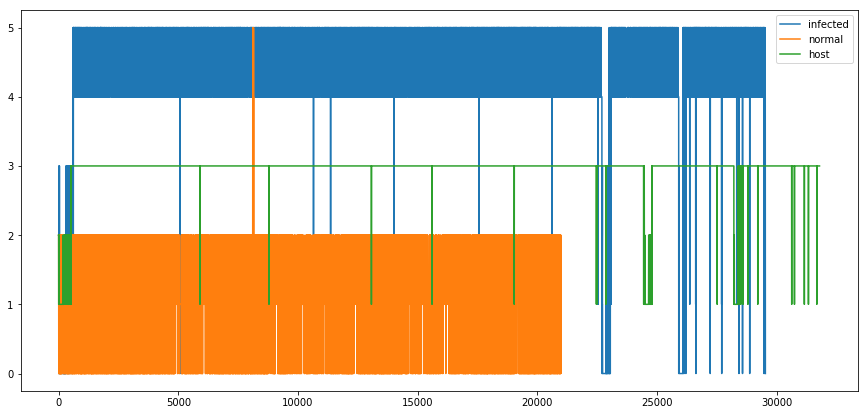

In [43]:
plt.figure(figsize=(15,7))
plt.plot(infected_code, label='infected')
plt.plot(normal_code, label='normal')
plt.plot(host_code, label='host')

plt.legend()

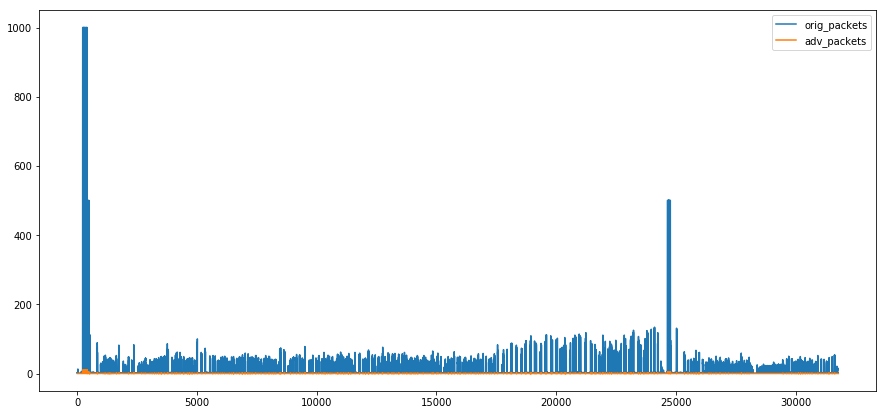

In [56]:
host_data = data_nobground[np.logical_or(data_nobground['Src_IP_Addr'] == test_hosts[0], data_nobground['Dst_IP_Addr']==test_hosts[0])]
host_data = host_data[feat].values

plt.figure(figsize=(15,7))
plt.plot(host_data[:,1], label='orig_packets')
plt.plot(host_data[:,1]*0.01, label='adv_packets')
plt.legend()

## Flow Classification

### Host Level

In [11]:
data_nobground.head()
data_perhost = data_nobground.groupby(by='Src_IP_Addr').agg({'Durat':'sum', 'Prot':'sum', 'Tos':'sum', 'Label':'max'})

In [15]:
data_perhost = data_nobground.groupby(by='Src_IP_Addr').agg({'Durat':'sum', 'Prot':'sum', 'Flags':'sum', 'Tos':'sum', 'Packets':'sum', 'Bytes':'sum', 'Flows':'sum', 'Label':'max'})
data_perhost['Dst_IPs'] = data_nobground.groupby('Src_IP_Addr')['Dst_IP_Addr'].nunique()
data_perhost['Src_Ports'] = data_nobground.groupby('Src_IP_Addr')['Src_Port'].nunique()
data_perhost['Dst_Ports'] = data_nobground.groupby('Src_IP_Addr')['Dst_Port'].nunique()

hosts = data_perhost.index

labels = data_perhost['Label'].values
data_perhost.drop(labels='Label', axis=1, inplace=True)
X = data_perhost.values

print(X.shape)
print("Imbalance ratio: ", np.sum(labels)/np.sum(labels==0))

(522, 10)
Imbalance ratio:  0.14725274725274726


In [16]:
data_perhost.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Dst_IPs,Src_Ports,Dst_Ports
Src_IP_Addr,,,,,,,,,,
10.10.20.233,50.096,0,249,0,132,8712,75,1,23,1
10.168.115.232,3.624,0,20,0,9,778,5,1,1,1
10.168.48.160,4.897,0,16,0,6,534,4,1,1,1
10.23.106.55,3.565,0,8,0,6,511,2,1,1,1
10.23.12.43,4.556,0,16,0,6,1583,4,2,2,2


In [18]:
print("Imbalance ratio: ", np.sum(labels)/len(labels))

Imbalance ratio:  0.12835249042145594


In [19]:
num_splits = 2
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)

In [22]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, False)

In [25]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[ 11   6]
 [ 56 449]]
Accuracy: 0.881
Precision: 0.647
Recall: 0.164
F1_score: 0.262


In [26]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)

_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[ 37   6]
 [ 30 449]]
Accuracy: 0.931
Precision: 0.860
Recall: 0.552
F1_score: 0.673


Attacks

In [28]:
clf = GaussianNB()
_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, True)

In [29]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[ 11   7]
 [ 56 448]]
Accuracy: 0.879
Precision: 0.611
Recall: 0.164
F1_score: 0.259


In [30]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)

_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, True)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [31]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[ 25   7]
 [ 42 448]]
Accuracy: 0.906
Precision: 0.781
Recall: 0.373
F1_score: 0.505


### Packet Level

In [12]:
# Storing the mapping used for the conversion, in case we want to revert back 
label_mapping = {}
data_num = data_nobground.copy()

# Convert currency code in order to 'amount' in a single code

# Convert all the rest columns which are of type 'object'
label_mapping['Label'] = {'LEGITIMATE':0, 'Botnet':1}
data_num.replace({'Label' : label_mapping['Label']}, inplace=True)
char_cols = data_nobground.dtypes.pipe(lambda x: x[x == 'object']).index

for c in char_cols:
    data_num[c], label_mapping[c] = pd.factorize(data_nobground[c])

# Uncomment this line, if you want to see the mapppings for the conversion
#label_mapping

In [13]:
labels = data_num['Label'].values
data_num.drop(labels=['Label', 'Datetime'], axis=1, inplace=True)
data_num.head()

,Durat,Prot,Flags,Tos,Packets,Bytes,Flows,Src_IP_Addr,Src_Port,Dst_IP_Addr,Dst_Port
20,4.985,0,0,0,91,86277,1,0,0,0,0
51,0.000,0,1,0,1,66,1,1,1,1,1
57,4.921,0,1,0,49,3234,1,2,2,2,2
73,4.742,0,1,0,118,7080,1,3,3,3,2
75,0.000,0,1,0,1,60,1,3,4,4,1


In [19]:
X = data_num.values
print(X.shape)

(645358, 11)


In [22]:
num_splits = 2
cv = StratifiedKFold(n_splits = num_splits, shuffle = True)
np.sum(labels)

323441

In [84]:
feat = [0,4,5]
clf = GaussianNB()
y_pred=[]
y_pred_adv = []
for train_index, test_index in cv.split(X, labels):
    clf.fit(X[train_index], labels[train_index])
    
    X_test = X[test_index]
    y_pred.append(clf.predict(X_test))
    
    mal_inds = np.where(labels[test_index]==1)[0][...,np.newaxis]
    perturb = [2,10,1024]
    perturb = np.tile(perturb,[len(mal_inds), 1])
    print(X_test[mal_inds[0], :])
    X_test[mal_inds, feat] = X_test[mal_inds, feat] + perturb 
    print(X_test[mal_inds[0], :], "\n")
    
    y_pred_adv.append(clf.predict(X_test))

[[  0.   0.  10.   0.   1.  66.   1.  63. 583.  98. 111.]]
[[2.00e+00 0.00e+00 1.00e+01 0.00e+00 1.10e+01 1.09e+03 1.00e+00 6.30e+01
  5.83e+02 9.80e+01 1.11e+02]] 

[[0.000e+00 1.000e+00 5.000e+00 0.000e+00 1.000e+00 6.400e+01 1.000e+00
  1.260e+02 4.105e+03 3.100e+01 1.200e+01]]
[[2.000e+00 1.000e+00 5.000e+00 0.000e+00 1.100e+01 1.088e+03 1.000e+00
  1.260e+02 4.105e+03 3.100e+01 1.200e+01]] 



0


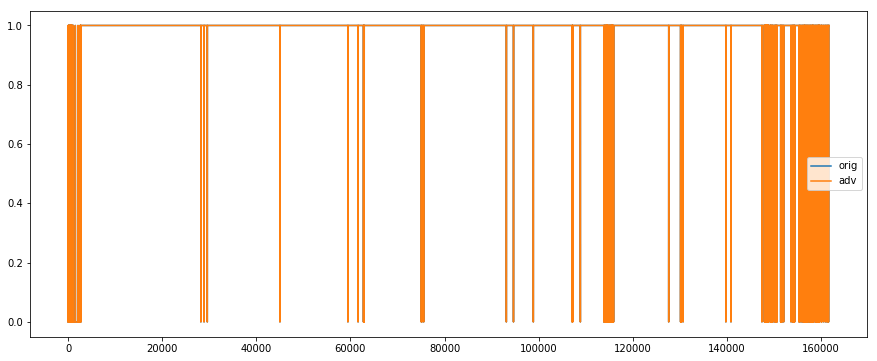

In [83]:
orig = y_pred[1][labels[test_index]==1]
adv = y_pred_adv[1][labels[test_index]==1]

print(np.sum(orig!=adv))

plt.figure(figsize=(15,6))
plt.plot(orig, label='orig')
plt.plot(adv, label='adv')
plt.legend()

In [104]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, False)

In [105]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[313587   4481]
 [  9854 317436]]
Accuracy: 0.978
Precision: 0.986
Recall: 0.970
F1_score: 0.978


In [89]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)

_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, False)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [90]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[323422     11]
 [    19 321906]]
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1_score: 1.000


Attacks

In [107]:
clf = GaussianNB()
_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, True)

In [108]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[314709   4471]
 [  8732 317446]]
Accuracy: 0.980
Precision: 0.986
Recall: 0.973
F1_score: 0.979


In [100]:
from  sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators='warn', criterion='gini', min_samples_split=2, min_samples_leaf=1, 
         min_weight_fraction_leaf=0.0, max_features='auto', min_impurity_decrease=0.0, 
         bootstrap=True, n_jobs=-1, verbose=0, warm_start=False)

_, _, _, _, _, _, cm = roc_analysis(X, labels, clf, cv, False, False, True)

/home/ilele/.conda/envs/cda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [101]:
print(cm)

acc, prec, rec, F1 = performance_metrics(cm)

print("Accuracy: %.3f" %acc)
print("Precision: %.3f" %prec)
print("Recall: %.3f" %rec)
print("F1_score: %.3f" %F1)

[[319568      2]
 [  3873 321915]]
Accuracy: 0.994
Precision: 1.000
Recall: 0.988
F1_score: 0.994


In [24]:
def performance_metrics(cm):
    accuracy = (cm[0,0] + cm[1,1])/np.sum(cm)
    precision = cm[0,0]/(cm[0,0]+cm[0,1])
    recall = cm[0,0]/(cm[0,0]+cm[1,0])
    F1_score = 2*(precision*recall)/(precision+recall)

    return accuracy, precision, recall, F1_score

In [21]:
def roc_analysis(X, y, clf, cv, plot_all_ROC, plot_ROC, attack=False, sm=None):
    # vectors for storing True Positives, False Negatives, False Positives and True negatives
    # respectively per cross-validation run
    num_splits = cv.get_n_splits()
    TP = np.zeros(num_splits, dtype=int)
    FN = np.zeros_like(TP)
    FP = np.zeros_like(TP)
    TN = np.zeros_like(TP)


    # Likewise for storing precision, recall and F1 score respectively extracted,
    # per cross-validation run
    PR = np.zeros(num_splits)
    R = np.zeros_like(PR)
    F1 = np.zeros_like(PR)

    # Likewise for the True Positive Rate and the Area Under Curve
    TPR = []
    AUC = []
    mean_FPR = np.linspace(0, 1, 100)

    i = 0
    if plot_ROC:
        plt.figure(figsize=(8, 10))

    # Cross-validation
    for train_index, test_index in cv.split(X, y):
        # If sm is provided, after extracting the split we first perform SMOTE on
        # training data and then proceed to training the classifier
        if sm != None:
            X_train, y_train = sm.fit_resample(X[train_index], y[train_index])
        else:
            X_train, y_train = X[train_index], y[train_index]

        # Train the classifier and extract predictions for test samples
        clf.fit(X_train, y_train)

        X_test = X[test_index]
        feat = [0,4,5]
        
        if attack:
            malicious_ind = np.where(y[test_index]==1)[0][..., np.newaxis]
            perturb = [120, 200, 2048]
            perturb = np.tile(perturb, [len(malicious_ind), 1])
            X_test[malicious_ind, feat] = X_test[malicious_ind, feat] + perturb
        
        y_pred = clf.predict(X_test)


        # Extract confusion matrix, precision, recall and F1 score for the current
        # run of cross validatin
        TN[i], FP[i], FN[i], TP[i] = confusion_matrix(y[test_index], y_pred).ravel()
        PR[i] = precision_score(y[test_index], y_pred, average='binary')
        R[i] = recall_score(y[test_index], y_pred, average='binary')
        F1[i] = f1_score(y[test_index], y_pred, average='binary')

        # Extract false positive and true positive rate correspoding to the positive (fraud) label
        fpr, tpr, thresholds = roc_curve(y[test_index], clf.predict_proba(X[test_index])[:, 1])

        # Interpolate extracted values on range of 0:100 with a step of 1
        TPR.append(np.interp(mean_FPR, fpr, tpr))

        # Set the first value of the run equal to 0
        TPR[-1][0] = 0.0

        # Extract and append to list the Area under Curve
        roc_auc = auc(fpr, tpr)
        AUC.append(roc_auc)

        # if TRUE all ROC curves correspodning to each run are plotted
        if plot_all_ROC:
            plt.plot(fpr, tpr, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i = i + 1

    # Extract mean values and standard deviations per run
    mean_TPR = np.mean(TPR, 0)
    mean_TPR[-1] = 1.0
    std_TPR = np.std(TPR, 0)
    # To assure that it doesn't go out of the graph
    upper_TPR = np.minimum(mean_TPR + std_TPR, 1)
    lower_TPR = np.maximum(mean_TPR - std_TPR, 0)

    mean_AUC = auc(mean_FPR, mean_TPR)
    std_AUC = np.std(AUC)

    mean_PR = np.mean(PR)
    mean_R = np.mean(R)
    mean_F1 = np.mean(F1)
    std_F1 = np.std(F1)

    # If true plot the mean ROC curve
    if plot_ROC:
        # Line corresponding to the 'Chance' classifier (50-50)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
                 label='Chance', alpha=.8)

        plt.plot(mean_FPR, mean_TPR, color='b',
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_AUC, std_AUC),
                 lw=2, alpha=.8)
        plt.fill_between(mean_FPR, lower_TPR, upper_TPR, color='b', alpha=.2,
                         label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic curve')
        plt.legend(loc="lower right")
        plt.show()

    # Extract the overall confusion matrix, by summing up the values extracted
    # from all runs.
    cm = np.array([[np.sum(TP), np.sum(FP)], [np.sum(FN), np.sum(TN)]])

    return mean_TPR, std_TPR, mean_AUC, std_AUC, mean_F1, std_F1, cm